<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# Exploratory Data Analysis

This notebook walks you through the steps to exploratory data analysis.

In [1]:
from radiant_mlhub import Collection
import tarfile
import os
from pathlib import Path
import json

import datetime
import rasterio
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit
import pickle

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score,balanced_accuracy_score#,plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
df = pd.DataFrame()
for value in ['df_mean_1','df_mean_2']:#['df_median_76_1','df_median_76_2','df_median_76_3','df_median_76_4','df_median_76_5']
    print('Reading Train df:', value)
    #read the pickle file
    picklefile = open(value, 'rb')
    #unpickle the dataframe
    df_tmp = pickle.load(picklefile)
    #close file
    picklefile.close()
    df = pd.concat([df,df_tmp])
    print(len(df_tmp))

Reading Train df: df_mean_1
3603
Reading Train df: df_mean_2
3571


In [3]:
df.reset_index(inplace=True,drop=True)
df

,field_id,20170401_B01,20170401_B02,20170401_B03,20170401_B04,20170401_B05,20170401_B06,20170401_B07,20170401_B08,20170401_B09,...,20171127_B04,20171127_B05,20171127_B06,20171127_B07,20171127_B08,20171127_B09,20171127_B11,20171127_B12,20171127_B8A,label
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.728477,62.543046,70.079470,75.827815,84.913907,79.523179,113.364238,88.715232,84.841060,8
1,91.0,21.752000,25.448000,34.880000,45.668000,52.108000,56.116000,60.932000,65.100000,70.264000,...,41.936000,48.076000,52.612000,56.956000,62.296000,65.884000,107.628000,90.520000,65.084000,3
2,243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.823529,40.787330,65.063348,73.606335,77.072398,81.416290,88.045249,65.837104,80.013575,4
3,286.0,12.799127,15.448690,22.437773,29.348253,36.932314,45.018559,50.018559,54.330786,58.465066,...,26.365721,37.413755,54.512009,60.182314,65.986900,66.938865,71.457424,48.434498,66.165939,2
4,308.0,21.242424,28.000000,45.696970,63.393939,72.363636,76.393939,81.424242,84.363636,88.454545,...,67.060606,75.969697,79.515152,84.333333,90.515152,88.787879,120.030303,91.060606,91.393939,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,122508.0,17.882353,24.026738,39.647059,61.663102,74.443850,81.604278,89.454545,96.427807,100.459893,...,62.946524,70.994652,75.064171,79.877005,86.518717,87.967914,118.203209,88.754011,87.534759,6
7170,122532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.694613,72.773900,74.878983,78.177542,82.427542,84.045524,118.080804,92.821700,83.049317,7
7171,122534.0,10.294444,13.766667,23.766667,33.611111,42.661111,50.727778,55.472222,59.577778,60.716667,...,39.122222,52.544444,72.127778,79.083333,85.738889,84.433333,95.638889,64.038889,84.761111,4
7172,122585.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.760870,56.510870,80.326087,89.239130,95.054348,91.978261,104.000000,82.456522,93.358696,4


In [4]:
df['label'].value_counts()

4    2133
7    1220
2    1037
1     767
6     684
5     503
3     474
8     209
9     147
Name: label, dtype: int64

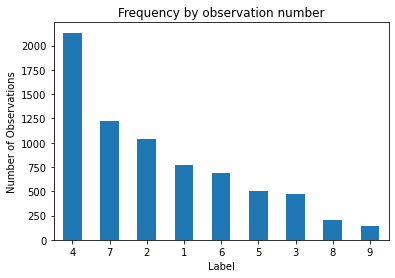

In [5]:
count_labels = pd.value_counts(df['label'], sort = True)
count_labels.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Label")
plt.ylabel("Number of Observations");

In [6]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns].head())

   20170401_B01  20170401_B02  20170401_B03  20170401_B04  20170401_B05  \
0           NaN           NaN           NaN           NaN           NaN   
1     21.752000      25.44800     34.880000     45.668000     52.108000   
2           NaN           NaN           NaN           NaN           NaN   
3     12.799127      15.44869     22.437773     29.348253     36.932314   
4     21.242424      28.00000     45.696970     63.393939     72.363636   

   20170401_B06  20170401_B07  20170401_B08  20170401_B09  20170401_B11  ...  \
0           NaN           NaN           NaN           NaN           NaN  ...   
1     56.116000     60.932000     65.100000     70.264000    107.112000  ...   
2           NaN           NaN           NaN           NaN           NaN  ...   
3     45.018559     50.018559     54.330786     58.465066     68.554585  ...   
4     76.393939     81.424242     84.363636     88.454545    106.666667  ...   

   20171122_B03  20171122_B04  20171122_B05  20171122_B06  20171122_

In [7]:
df[df['label']==3].head(20)

,field_id,20170401_B01,20170401_B02,20170401_B03,20170401_B04,20170401_B05,20170401_B06,20170401_B07,20170401_B08,20170401_B09,...,20171127_B04,20171127_B05,20171127_B06,20171127_B07,20171127_B08,20171127_B09,20171127_B11,20171127_B12,20171127_B8A,label
1,91.0,21.752000,25.448000,34.880000,45.668000,52.108000,56.116000,60.932000,65.100000,70.264000,...,41.936000,48.076000,52.612000,56.956000,62.296000,65.884000,107.628000,90.520000,65.084000,3
7,453.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54.252174,61.017391,64.721739,68.573913,73.452174,73.234783,108.939130,96.365217,72.921739,3
14,705.0,22.708333,27.541667,41.333333,56.541667,62.000000,66.833333,68.708333,72.833333,75.000000,...,64.791667,70.291667,73.458333,76.916667,83.625000,82.041667,115.750000,101.041667,81.791667,3
15,726.0,14.077465,19.267606,36.169014,59.070423,66.535211,69.295775,72.760563,73.450704,74.302817,...,59.802817,66.464789,69.922535,72.950704,75.690141,74.816901,117.816901,98.239437,75.697183,3
20,883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.378049,65.451220,70.792683,76.280488,82.634146,82.158537,118.975610,103.134146,81.329268,3
38,1477.0,20.348168,22.774869,32.272251,44.591623,53.157068,61.410995,67.821990,74.018325,79.518325,...,60.080000,69.510000,78.352500,84.650000,92.437500,95.747500,118.080000,95.930000,94.525000,3
62,2236.0,16.800000,22.600000,36.100000,52.600000,57.800000,60.800000,64.400000,65.800000,65.800000,...,70.000000,75.000000,80.000000,81.200000,89.000000,80.400000,123.200000,110.600000,87.800000,3
81,2790.0,22.067932,24.913472,39.634915,61.564706,70.743074,73.299051,76.615180,75.223909,91.463757,...,71.440987,80.748387,84.702467,88.032258,89.421632,88.546110,136.737761,121.780645,88.654269,3
98,3461.0,12.800000,20.600000,32.000000,40.200000,42.600000,49.400000,53.800000,56.400000,62.400000,...,50.800000,52.600000,69.200000,77.000000,78.800000,92.400000,89.400000,62.600000,81.400000,3
103,3510.0,22.099024,28.302650,40.677824,53.979079,60.818689,64.560669,68.333333,73.213389,101.755927,...,24.227336,36.372385,71.317992,82.513250,87.776848,85.732218,54.931660,39.736402,86.566248,3


In [8]:
#Test
field_id_example = 6652.0
idx_example = df[df['field_id']==field_id_example].index[0]
#df[df['field_id']==field_id_example].loc[:,['20170401_B8A','20170404_B8A','20171127_B8A']]

#### Nota:
- Se observa desbalanceo en el df de los cultivos a estudiar.
- En caso de presencia de nubes (ayudado por la variable CLM) se ha reemplazado los valores originales por valor Nan en las bandas espectrales de Sentinel-2, en diferentes momentos y diferentes parcelas debido a la presencia de nubes/humo.

### Preprocesamiento - Ingeniería de Variables

#### Tratamiento nubes/humo (outlier) bandas Sentinel-2

##### Demostración Gráfica Interpolación nubes/humo (outlier)

In [9]:
cols=[]
cols += (df.filter(regex='._B04').columns).tolist()
banda_ts = pd.DataFrame({
    'Fecha': df[cols].iloc[idx_example].filter(regex='.B04').index, 
    'Banda4':df[cols].iloc[idx_example].filter(regex='.B04').values
})
new = banda_ts['Fecha'].str.split("_", n = 1, expand = True) 
banda_ts['Fecha']= new[0] 

In [10]:
# Convert a datetime
banda_ts['Fecha'] = pd.to_datetime(banda_ts['Fecha'], dayfirst=True)
banda_ts.head()

,Fecha,Banda4
0,2017-04-01,21.131579
1,2017-04-11,21.618421
2,2017-04-21,18.013158
3,2017-05-01,NaN
4,2017-05-11,NaN


In [11]:
banda_ts['Banda4'].isna().value_counts()/len(banda_ts)*100

False    65.789474
True     34.210526
Name: Banda4, dtype: float64

In [12]:
banda_ts = banda_ts.set_index('Fecha')

,Banda4
Fecha,
2017-04-01,21.131579
2017-04-11,21.618421
2017-04-21,18.013158
2017-05-01,NaN
2017-05-11,NaN


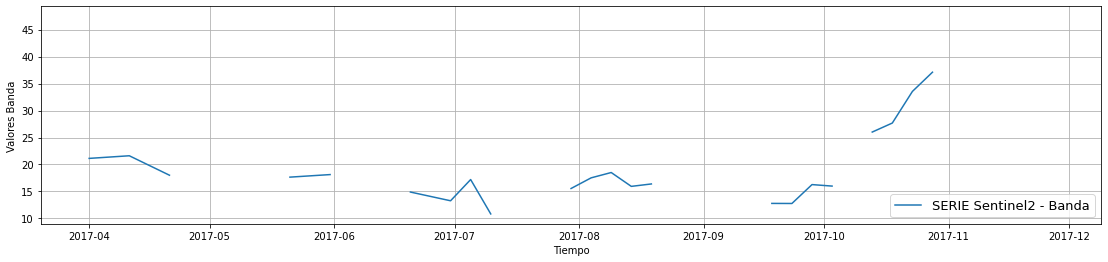

In [13]:
# Finalmente es posible plotear la serie temporal
fig, axes = plt.subplots(figsize=(19,4))
axes.plot(banda_ts.iloc[:,0], label='SERIE Sentinel2 - Banda')
axes.set_xlabel('Tiempo')
axes.set_ylabel('Valores Banda')
axes.grid(True)
axes.legend(loc='lower right', fontsize=13)
banda_ts.iloc[:,0:2].head()

In [14]:
banda_ts['Interp1'] = banda_ts['Banda4'].interpolate(method='linear',limit_direction ='backward')
banda_ts['Interp1']=banda_ts['Interp1'].interpolate(method='linear',limit_direction ='forward')
banda_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 2017-04-01 to 2017-11-27
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Banda4   25 non-null     float64
 1   Interp1  38 non-null     float64
dtypes: float64(2)
memory usage: 912.0 bytes


In [15]:
dt1 =pd.DataFrame({'B4_original':banda_ts['Banda4'].values,
                                          'Interp. B4':banda_ts['Interp1'].values,
                                          }, columns=['B4_original','Interp. B4'],index=banda_ts.index)
dt1.head(10)

,B4_original,Interp. B4
Fecha,,
2017-04-01,21.131579,21.131579
2017-04-11,21.618421,21.618421
2017-04-21,18.013158,18.013158
2017-05-01,NaN,17.894737
2017-05-11,NaN,17.776316
2017-05-21,17.657895,17.657895
2017-05-31,18.131579,18.131579
2017-06-10,NaN,16.513158
2017-06-20,14.894737,14.894737


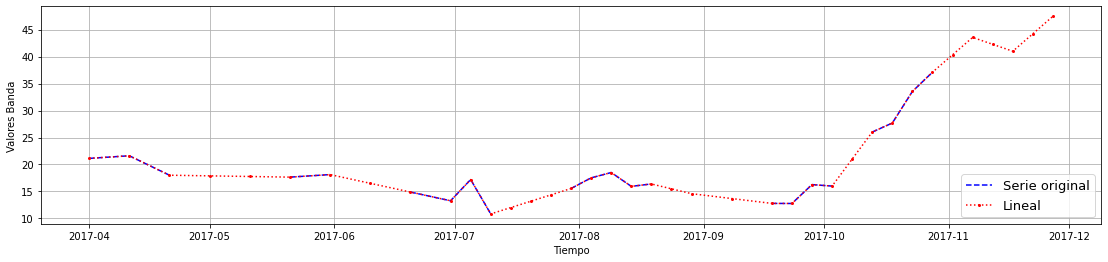

In [16]:
# Finalmente es posible plotear la serie temporal
fig, axes = plt.subplots(figsize=(19,4))
axes.plot(dt1['B4_original'], linestyle='--', ms = 4, color = 'blue', label='Serie original')
axes.plot(dt1['Interp. B4'], marker='.', ms=4, linestyle=':',color='red', label='Lineal')
axes.set_xlabel('Tiempo')
axes.set_ylabel('Valores Banda')
axes.grid(True)
axes.legend(loc='lower right', fontsize=13);

##### Aplicación al DF Interpolación nubes/humo (outlier)

In [17]:
def suavizado(col):
    cols=[]
    cols += (df.filter(regex=col).columns).tolist()
    df_banda = pd.DataFrame(columns = cols)
    df_banda_tmp = pd.DataFrame(columns = cols)
    banda = pd.DataFrame(columns = [col,'{}_I'.format(col)])
    for index, row in  df.iterrows():
        banda[col] = row.filter(regex='._{}'.format(col)).values
        #Interpolación
        banda['{}_I'.format(col)] = banda[col].interpolate(method='linear',limit_direction ='backward')
        banda['{}_I'.format(col)] =  banda['{}_I'.format(col)].interpolate(method='linear',limit_direction ='forward')
        #banda['{}_I'.format(col)] = banda[col].interpolate(method='spline',order=1,limit_direction ='backward')
        #banda['{}_I'.format(col)] =  banda['{}_I'.format(col)].interpolate(method='spline',order=1,limit_direction ='forward')
        # Dejamos los valores de la banda en una variable
        st = banda['{}_I'.format(col)].copy()
        #Suavizado de Hamunyela
        for i in np.arange(1, (len(st)-1),1):
            st[i] = np.where(((st[i]-st[i-1] < -0.01*st[i-1]) & 
                              (st[i]-st[i+1] < -0.01*st[i+1])), 
                             (st[i-1]+st[i+1])/2, st[i])
        df_banda_tmp = pd.DataFrame(data = st.values.reshape(1,len(df_banda_tmp.columns)), columns = df_banda_tmp.columns)
        frames = [df_banda, df_banda_tmp]
        df_banda = pd.concat(frames)
        df_banda=df_banda.reset_index(drop=True)
    return df_banda

In [18]:
bands = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11', 'B12']
df_final = df.loc[:, ['field_id','label']]
for b in bands:
    df_banda = suavizado(b)
    df_final = pd.merge(df_final, df_banda, right_index=True, left_index=True)

In [19]:
df = df_final.copy()
df = df.reset_index(drop=True)
df

,field_id,label,20170401_B01,20170411_B01,20170421_B01,20170501_B01,20170511_B01,20170521_B01,20170531_B01,20170610_B01,...,20171013_B12,20171018_B12,20171023_B12,20171028_B12,20171102_B12,20171107_B12,20171112_B12,20171117_B12,20171122_B12,20171127_B12
0,4.0,8,25.953642,25.953642,18.728477,18.319536,18.924669,19.529801,24.536424,19.682119,...,55.887417,56.394040,56.900662,57.423841,66.562914,75.701987,81.337748,86.973510,87.844371,88.715232
1,91.0,3,21.752000,20.756000,20.628000,19.848000,18.792000,17.736000,17.788000,15.740000,...,80.744000,79.896000,79.048000,78.560000,82.588000,86.616000,92.116000,90.720000,90.620000,90.520000
2,243.0,4,1.144796,1.144796,1.343891,1.846154,4.355204,6.864253,13.916290,20.968326,...,71.393665,70.631222,69.868778,70.468326,71.067873,70.633484,71.083710,71.533937,68.685520,65.837104
3,286.0,2,12.799127,11.468341,10.575328,10.588792,10.602256,10.615721,10.888646,8.284934,...,45.653930,33.513100,38.641376,43.769651,45.152838,46.536026,47.268559,48.001092,48.217795,48.434498
4,308.0,7,21.242424,20.106061,18.969697,15.676768,12.383838,14.388889,16.393939,12.833333,...,51.939394,54.545455,57.151515,59.121212,61.393939,63.666667,68.606061,73.545455,82.303030,91.060606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,122508.0,6,17.882353,17.224599,16.566845,14.860963,13.155080,14.858289,16.561497,12.622995,...,62.545455,65.385027,68.224599,67.877005,70.949198,74.021390,75.510695,77.000000,82.877005,88.754011
7170,122532.0,7,11.643778,11.643778,17.743551,17.719651,17.695751,17.671851,17.988998,14.575493,...,54.405918,57.454666,60.503414,61.616085,64.430956,67.245827,79.133725,91.021624,91.921662,92.821700
7171,122534.0,4,10.294444,11.822222,23.088889,34.355556,22.438889,16.880556,11.322222,8.565278,...,63.666667,64.461111,65.255556,60.761111,61.269444,61.777778,62.872222,63.966667,64.002778,64.038889
7172,122585.0,4,8.293478,8.293478,9.815217,11.336957,10.956522,13.875000,16.793478,11.945652,...,85.195652,84.304348,83.413043,82.100543,82.039402,81.978261,81.652174,81.326087,81.891304,82.456522


In [20]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [21]:
#Test
#df[df['field_id']==field_id_example].loc[:,['20170401_B8A','20170404_B8A','20171127_B8A']]

#### Cálculo Indices de vegetación

Para el cálculo de los diferentes índices de vegetación me he basado en los siguientes links:

- [Link1](https://acolita.com/lista-de-indices-espectrales-en-sentinel-2-y-landsat/)
- [Link2](https://mappinggis.com/2020/07/los-6-indices-de-vegetacion-para-completar-el-ndvi/#:~:text=Los%20%C3%8Dndices%20de%20Vegetaci%C3%B3n%20son,suelo%2C%20la%20iluminaci%C3%B3n%2C%20etc.)

In [22]:
datetime_variable = 38 #76

- ##### Indice NDVI

In [23]:
# NDVI :(B8A-B04)/(B8A+B04)
B8A_features_col = df.filter(regex='._B8A').columns
B4_features_col = df.filter(regex='._B04').columns
NDVI = []
for i in range(datetime_variable) :
    B8A = '{}'.format(B8A_features_col[i])
    B4 = '{}'.format(B4_features_col[i])
    NDVI.append('{}_NDVI'.format(B8A.split("_")[0]))
    df['{}_NDVI'.format(B8A.split("_")[0])] = (df[B8A]-df[B4])/(df[B8A]+df[B4])

- ##### Indice SLAVI

In [24]:
# SLAVI :(B8A)/(B8A+B12)
#https://www.indexdatabase.de/db/i-single.php?id=89
B12_features_col = df.filter(regex='._B12').columns
SLAVI = []
for i in range(datetime_variable) :
    B8A = '{}'.format(B8A_features_col[i])
    B12 = '{}'.format(B12_features_col[i])
    SLAVI.append('{}_SLAVI'.format(B8A.split("_")[0]))
    df['{}_SLAVI'.format(B8A.split("_")[0])] = (df[B8A])/(df[B8A]+df[B12])

- ##### Indice SAVI

In [25]:
# # SAVI :1.5*(B8A-B04)/(B8A+B04+0.5)
#SAVI = []
#for i in range(datetime_variable) :
#    B8A = '{}'.format(B8A_features_col[i])
#    B4 = '{}'.format(B4_features_col[i])
#    SAVI.append('{}_SAVI'.format(B8A.split("_")[0]))
#    df['{}_SAVI'.format(B8A.split("_")[0])] = (1.5*(df[B8A].divide(10000)-df[B4].divide(10000))/(df[B8A].divide(10000)+df[B4].divide(10000)+0.5)).multiply(10000)

- ##### Indice RECI

In [26]:
#RECI :(B08/B04)-1
#B8_features_col = df.filter(regex='._B08').columns
#RECI = []
#for i in range(datetime_variable) :
#    B8 = '{}'.format(B8_features_col[i])
#    B4 = '{}'.format(B4_features_col[i])
#    RECI.append('{}_RECI'.format(B8.split("_")[0]))
#    df['{}_RECI'.format(B8.split("_")[0])] = (((df[B8]).divide(10000)/(df[B4]).divide(10000))-1).multiply(10000)

- ##### Indice MSI

In [27]:
# MSI :B11/B8A
B11_features_col = df.filter(regex='._B11').columns
MSI = []
for i in range(datetime_variable) :
    B8A = '{}'.format(B8A_features_col[i])
    B11 = '{}'.format(B11_features_col[i])
    MSI.append('{}_MSI'.format(B8A.split("_")[0]))
    df['{}_MSI'.format(B8A.split("_")[0])] = (df[B11])/(df[B8A])

- ##### Indice NDRE

In [28]:
# NDRE :(B09-B05)/(B09+B05)
B9_features_col = df.filter(regex='._B09').columns
B5_features_col = df.filter(regex='._B05').columns
NDRE = []
for i in range(datetime_variable) :
    B9 = '{}'.format(B9_features_col[i])
    B5 = '{}'.format(B5_features_col[i])
    NDRE.append('{}_NDRE'.format(B9.split("_")[0]))
    df['{}_NDRE'.format(B9.split("_")[0])] =  (df[B9]-df[B5])/(df[B9]+df[B5])

In [29]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns])

Empty DataFrame
Columns: []
Index: []


In [30]:
#df.dropna(inplace=True)
#df.fillna(0,inplace=True)

#### Cálculo Estádisticos para cada Indice espectral (PENDIENTE)

Se procede a calcular ciertas medidas estadísticas por cada índice de vegetación calculado a partir del aspecto temporal de los mismos:
   - Desviación standard, 
   - Máximo, 
   - Mínimo y 
   - Media

In [31]:
df = df.reset_index(drop=True)
df

,field_id,label,20170401_B01,20170411_B01,20170421_B01,20170501_B01,20170511_B01,20170521_B01,20170531_B01,20170610_B01,...,20171013_NDRE,20171018_NDRE,20171023_NDRE,20171028_NDRE,20171102_NDRE,20171107_NDRE,20171112_NDRE,20171117_NDRE,20171122_NDRE,20171127_NDRE
0,4.0,8,25.953642,25.953642,18.728477,18.319536,18.924669,19.529801,24.536424,19.682119,...,0.302382,0.285211,0.266438,0.235549,0.193131,0.185572,0.131393,0.116836,0.118143,0.119523
1,91.0,3,21.752000,20.756000,20.628000,19.848000,18.792000,17.736000,17.788000,15.740000,...,0.224935,0.204333,0.202813,0.213588,0.192320,0.171503,0.160512,0.167651,0.161954,0.156265
2,243.0,4,1.144796,1.144796,1.343891,1.846154,4.355204,6.864253,13.916290,20.968326,...,0.204697,0.219156,0.158911,0.126250,0.237147,0.259827,0.273358,0.299414,0.316168,0.332469
3,286.0,2,12.799127,11.468341,10.575328,10.588792,10.602256,10.615721,10.888646,8.284934,...,0.327770,0.327487,0.319744,0.312398,0.310521,0.308727,0.301852,0.294909,0.288862,0.282936
4,308.0,7,21.242424,20.106061,18.969697,15.676768,12.383838,14.388889,16.393939,12.833333,...,0.221121,0.191864,0.158842,0.145888,0.144987,0.130112,0.153846,0.173459,0.123062,0.077800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7169,122508.0,6,17.882353,17.224599,16.566845,14.860963,13.155080,14.858289,16.561497,12.622995,...,0.192908,0.185765,0.158380,0.161692,0.164759,0.172865,0.166846,0.161004,0.131058,0.106775
7170,122532.0,7,11.643778,11.643778,17.743551,17.719651,17.695751,17.671851,17.988998,14.575493,...,0.205835,0.138192,0.132445,0.126125,0.107965,0.103375,0.089085,0.079168,0.075638,0.071876
7171,122534.0,4,10.294444,11.822222,23.088889,34.355556,22.438889,16.880556,11.322222,8.565278,...,0.218700,0.225249,0.231525,0.223043,0.224099,0.225121,0.224827,0.224544,0.228723,0.232803
7172,122585.0,4,8.293478,8.293478,9.815217,11.336957,10.956522,13.875000,16.793478,11.945652,...,0.174865,0.177999,0.181105,0.186296,0.206120,0.216822,0.224780,0.232522,0.235725,0.238855


In [32]:
#Verificamos si hay valores nulos a causa de presencia de nubes/humo (variable CLM)
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()
print(df[df.isnull().any(axis=1)][null_columns])

Empty DataFrame
Columns: []
Index: []


### Creación Modelos

https://relopezbriega.github.io/blog/2016/05/29/machine-learning-con-python-sobreajuste/

In [33]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Matriz Confusión',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [34]:
l_modelo=[]
l_exactitud=[]
l_bexactitud=[]
l_precision=[]
l_exhaustividad=[]
l_f1=[]
#Función que nos permite representar las métricas
def metricas_modelos(modelo,y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    #print(u'Matriz de confusión:')
    #print(cm)

    print("-----Métricas------")
    print(u'Número de muestras clasificadas correctamente:', accuracy_score(y_true, y_pred, normalize=False))
    print(u'Exactitud:', accuracy_score(y_true, y_pred))
    print("Balance Accuracy score:",balanced_accuracy_score(y_true, y_pred))
    print(u'Precision:', precision_score(y_true, y_pred,average='weighted'))
    print(u'Exhaustividad:', recall_score(y_true, y_pred,average='weighted'))
    print(u'F1:', f1_score(y_true, y_pred,average='weighted'))
    print("-------------------")
    print(classification_report(y_true, y_pred))
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cm, classes=labels)
    
    l_modelo.append(modelo)
    l_exactitud.append(accuracy_score(y_true, y_pred)*100)
    l_bexactitud.append(balanced_accuracy_score(y_true, y_pred)*100)
    l_precision.append(precision_score(y_true, y_pred,average='weighted')*100)
    l_exhaustividad.append(recall_score(y_true, y_pred,average='weighted')*100)
    l_f1.append(f1_score(y_true, y_pred,average='weighted')*100)

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
class PreprocessTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,num_features):
        #cat_features, num_features
        #self.cat_features = cat_features
        self.num_features = num_features
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        # Treat ? workclass as unknown
        #df.loc[df['workclass'] == '?', 'workclass'] = 'Unknown'
        # Too many categories, just convert to US and Non-US
        #df.loc[df['native.country']!='United-States','native.country']='non_usa'
        # Convert columns to categorical
        #for name in self.cat_features:
        #    col = pd.Categorical(df[name])
        #    df[name] = col.codes
        # Normalize numerical features
        scaler = MinMaxScaler()
        df[self.num_features] = scaler.fit_transform(df[self.num_features])
        return df

In [36]:
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
  df.drop(['field_id','label'], axis=1),
  df['label'],
  test_size=0.3,
  random_state=42,
  shuffle=True,
  stratify=df['label']
)

#### Escalado Estándard:

Escalamos/Normalizamos el conjunto de datos antes de utilizarlos en los diferentes modelos. Es una buena práctica, para que los valores de las diferentes variables se encuentren en un mismo rango y de esta manera no influya una más que otra al momento de entrenar los modelos propuestos.
Este escalado, utiliza la media y la desviación típica para escalar y es bastante sensible en presencia de los outlier (humo/nubes) identificados. De todos modo ha sido el escalado que me ha dado mejor resultado por eso lo he seleccionado.

In [37]:
scaler = StandardScaler() #MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

#### Reducción Dimensionalidad (PENDIENTE)
Aplicamos PCA tanto a las bandas cómo a los índices de vegetación, con la intención de obtener una variable "representativa" de la "temporalidad" de la información

#### Model Random Forest Classifier

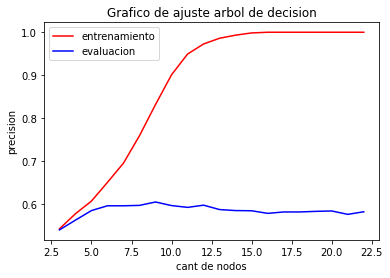

In [38]:
# Grafico de ajuste del árbol de decisión
train_prec =  []
eval_prec = []
max_deep_list = list(range(3, 23))

for deep in max_deep_list:
    rf = DecisionTreeClassifier(criterion='entropy', max_depth=deep)
    rf.fit(X_train, y_train)
    train_prec.append(rf.score(X_train, y_train))
    eval_prec.append(rf.score(X_test, y_test))

# graficar los resultados.
plt.plot(max_deep_list, train_prec, color='r', label='entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='evaluacion')
plt.title('Grafico de ajuste arbol de decision')
plt.legend()
plt.ylabel('precision')
plt.xlabel('cant de nodos')
plt.show()

#### Conclusión
El gráfico que acabamos de construir se llama gráfico de ajuste y muestra la precisión del modelo en función de su complejidad. En nuestro ejemplo, podemos ver que el punto con mayor precisión, en los datos de test, lo obtenemos con un nivel de profundidad de aproximadamente 6 nodos; a partir de allí el modelo pierde en generalización y comienza a estar sobreajustado. Por lo tanto utilizaremos el parámetro max_depth = 6.

In [39]:
# We ran a simple hyperparameter tuning for the number of trees, and concluded to use:
n_trees = 50
md = 6

In [40]:
# Fitting the RF model
model_rf = RandomForestClassifier(n_estimators = n_trees, random_state = 0, n_jobs = 3,max_depth=md)
model_rf.fit(X_train, y_train.astype(int))

RandomForestClassifier(max_depth=6, n_estimators=50, n_jobs=3, random_state=0)

-----Métricas------
Número de muestras clasificadas correctamente: 3531
Exactitud: 0.7032463652658832
Balance Accuracy score: 0.5141294703560284
Precision: 0.7144134016935486
Exhaustividad: 0.7032463652658832
F1: 0.6775804043502183
-------------------
              precision    recall  f1-score   support

           1       0.59      0.53      0.56       537
           2       0.53      0.70      0.61       726
           3       0.70      0.33      0.45       332
           4       0.84      0.95      0.89      1493
           5       0.57      0.58      0.57       352
           6       0.74      0.39      0.51       478
           7       0.72      0.92      0.81       854
           8       1.00      0.03      0.05       146
           9       0.76      0.18      0.30       103

    accuracy                           0.70      5021
   macro avg       0.72      0.51      0.53      5021
weighted avg       0.71      0.70      0.68      5021



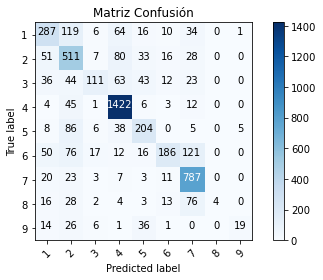

In [41]:
predictions = model_rf.predict(X_train)
metricas_modelos('RF',y_train, predictions, [1,2,3,4,5,6,7,8,9])

In [42]:
# precisión del modelo en datos de entrenamiento.
print("Exactitud entranamiento: {0: .2f}".format(
        model_rf.score(X_train, y_train)))

Exactitud entranamiento:  0.70


-----Métricas------
Número de muestras clasificadas correctamente: 1409
Exactitud: 0.6544356711565258
Balance Accuracy score: 0.46807802775398993
Precision: 0.6648201302124591
Exhaustividad: 0.6544356711565258
F1: 0.6271353785398069
-------------------
              precision    recall  f1-score   support

           1       0.51      0.45      0.48       230
           2       0.49      0.65      0.56       311
           3       0.55      0.23      0.32       142
           4       0.83      0.92      0.87       640
           5       0.49      0.54      0.52       151
           6       0.65      0.35      0.45       206
           7       0.67      0.88      0.76       366
           8       1.00      0.02      0.03        63
           9       0.89      0.18      0.30        44

    accuracy                           0.65      2153
   macro avg       0.68      0.47      0.48      2153
weighted avg       0.66      0.65      0.63      2153



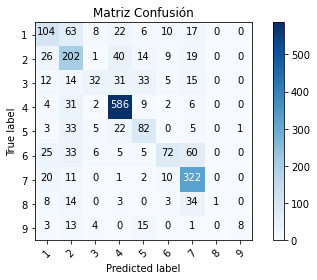

In [43]:
predictions = model_rf.predict(X_test)
metricas_modelos('RF',y_test, predictions, [1,2,3,4,5,6,7,8,9])

In [44]:
# precisión del modelo en datos de evaluación.
print("Exactitud test: {0: .2f}".format(
        model_rf.score(X_test, y_test)))

Exactitud test:  0.65


#### Model Ensembles: Bagging Classifier (SVC)

In [45]:
#Whether samples are drawn with replacement. If False, sampling without replacement is performed
#bootstrap=True->Bagging
#bootstrap=True->Pasting
clf = BaggingClassifier(base_estimator=SVC(),
                         n_estimators=10, random_state=0, bootstrap=False).fit(X_train, y_train)

-----Métricas------
Número de muestras clasificadas correctamente: 3851
Exactitud: 0.7669786895040829
Balance Accuracy score: 0.6420137467904095
Precision: 0.7736220312884085
Exhaustividad: 0.7669786895040829
F1: 0.7606478061582889
-------------------
              precision    recall  f1-score   support

           1       0.66      0.62      0.64       537
           2       0.59      0.79      0.67       726
           3       0.77      0.55      0.64       332
           4       0.90      0.95      0.92      1493
           5       0.67      0.64      0.65       352
           6       0.74      0.53      0.62       478
           7       0.82      0.91      0.86       854
           8       0.93      0.42      0.58       146
           9       0.75      0.38      0.50       103

    accuracy                           0.77      5021
   macro avg       0.76      0.64      0.68      5021
weighted avg       0.77      0.77      0.76      5021



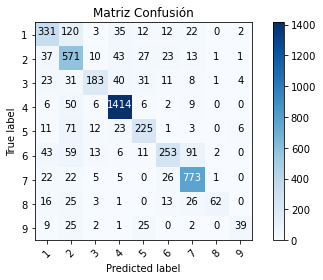

In [46]:
predictions = clf.predict(X_train)
metricas_modelos('BC',y_train, predictions, [1,2,3,4,5,6,7,8,9])

In [47]:
# precisión del modelo en datos de evaluación.
print("Exactitud entranamiento: {0: .2f}".format(
        clf.score(X_train, y_train)))

Exactitud entranamiento:  0.77


-----Métricas------
Número de muestras clasificadas correctamente: 1545
Exactitud: 0.7176033441709243
Balance Accuracy score: 0.5777446058890847
Precision: 0.7253218729187323
Exhaustividad: 0.7176033441709243
F1: 0.710454303310652
-------------------
              precision    recall  f1-score   support

           1       0.56      0.60      0.58       230
           2       0.53      0.73      0.61       311
           3       0.65      0.35      0.45       142
           4       0.91      0.93      0.92       640
           5       0.56      0.56      0.56       151
           6       0.62      0.49      0.55       206
           7       0.81      0.85      0.83       366
           8       0.81      0.35      0.49        63
           9       0.79      0.34      0.48        44

    accuracy                           0.72      2153
   macro avg       0.69      0.58      0.61      2153
weighted avg       0.73      0.72      0.71      2153



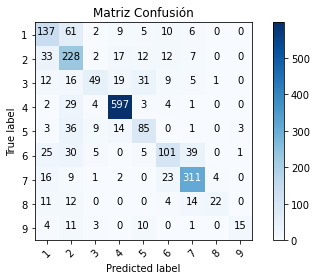

In [48]:
predictions = clf.predict(X_test)
metricas_modelos('BC',y_test, predictions, [1,2,3,4,5,6,7,8,9])

In [49]:
# precisión del modelo en datos de evaluación.
print("Exactitud test: {0: .2f}".format(
        clf.score(X_test, y_test)))

Exactitud test:  0.72


# PENDIENTEEEEEEEEEEEEEEEEEEEEE

In [ ]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
  df.drop(['field_id','label'], axis=1),
  df['label'],
  test_size=0.3,
  random_state=42,
  shuffle=True,
  stratify=df['label']
)

In [ ]:
random_state = 42
leaf_nodes = 5
num_features = 10
num_estimators = 100
numerical_features = X_train.columns.tolist()
# Decision tree for bagging
tree_clf = DecisionTreeClassifier(
  splitter='random',
  max_leaf_nodes=leaf_nodes,
  random_state=random_state
)
# Initialize the bagging classifier
bag_clf = BaggingClassifier(
  tree_clf,
  n_estimators=num_estimators,
  max_samples=1.0,
  max_features=1.0,
  random_state=random_state,
  n_jobs=-1
)
# Create a pipeline
pipe = Pipeline([
  ('preproc', PreprocessTransformer(numerical_features)),
  ('fs', SelectKBest()),
  ('clf', DecisionTreeClassifier())
])

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf': [DecisionTreeClassifier()],
    'clf__max_leaf_nodes': [128],
    'clf__max_depth':[4,5,6],
    'fs__score_func': [chi2],
    'fs__k': [200],
  },
  {
    'clf': [RandomForestClassifier()],
    'clf__n_estimators': [200],
    'clf__max_leaf_nodes': [128],
    'clf__bootstrap': [False, True],
    'clf__max_depth':[5,6],
    'fs__score_func': [chi2],
    'fs__k': [200],
  }
]
# Define scoring
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define cross validation
kfold = KFold(n_splits=100)#random_state=42
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
model = grid.fit(X_train, y_train)

In [ ]:
grid.cv_results_

In [ ]:
best_estimator = grid.best_estimator_.steps[-1][1]
columns = X_test.columns.tolist()
print('Feature Importances')
                             
for i, imp in enumerate(best_estimator.feature_importances_):
  print('{}: {:.3f}'.format(columns[i], imp))

In [ ]:
print('Mean Test Accuracy',grid.cv_results_['mean_test_Accuracy'],'\n')
print('Mean Test AUC',grid.cv_results_['mean_test_AUC'],'\n')
print('Parameters Best Model',grid.cv_results_['params'])

In [ ]:
grid.best_estimator_

In [ ]:
grid.best_estimator_.steps[-1][1]